In [1]:
pip install pdfminer.six pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.8 MB/s eta 0:00:00


In [2]:
from pdfminer.high_level import extract_text
import pandas as pd

# Ruta del archivo PDF
pdf_path = "2866851.pdf"
# pdf_path = "Los-miserables.pdf" # Para utilizar el libro de la Fundación Carlos Slim

# Extraer texto del PDF
text = extract_text(pdf_path)

# Dividir en líneas
lines = text.split("\n")

# Guardar en CSV
df = pd.DataFrame({"texto": lines})
df.to_csv("los_miserables.csv", index=False, encoding="utf-8")

print("Conversión a CSV completada.")


Conversión a CSV completada.


In [14]:
import pandas as pd
import re
import unicodedata

# Cargar el CSV
df = pd.read_csv("los_miserables.csv")

# Función para limpiar el texto
def clean_text(text):
    if pd.isna(text):  # Si el texto es NaN, devolver cadena vacía
        return ""
    text = text.lower()  # Convertir a minúsculas
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")  # Quitar acentos
    text = re.sub(r"[^a-z\s]", "", text)  # Eliminar todo excepto letras y espacios
    text = re.sub(r"\s+", " ", text).strip()  # Quitar espacios extra
    return text

print(df.isnull().sum())  # Muestra cuántos valores NaN hay por columna

df = df.dropna(subset=["texto"])  # Elimina filas donde la columna 'texto' tiene NaN
df["texto"] = df["texto"].astype(str)  # Convierte la columna a string para evitar problemas

# Aplicar limpieza a la columna de texto
df["texto"] = df["texto"].apply(clean_text)

# Guardar el archivo limpio
df.to_csv("los_miserables_limpio.csv", index=False, encoding="utf-8")

#print(df.isnull().sum())  # Muestra cuántos valores NaN hay por columna

print("Limpieza completada y guardada en 'los_miserables_limpio.csv'.")


texto    12200
dtype: int64
Limpieza completada y guardada en 'los_miserables_limpio.csv'.


In [17]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
from collections import Counter

# Cargar CSV limpio
df = pd.read_csv("los_miserables_limpio.csv")

#print(df.isnull().sum())  # Muestra cuántos valores NaN hay por columna

# Convertir a string y manejar NaN
df["texto"] = df["texto"].astype(str).fillna("")

#print(df.isnull().sum())  # Muestra cuántos valores NaN hay por columna

# Unir todo el texto en una sola cadena
full_text = " ".join(df["texto"])

# Tokenizar (dividir en palabras)
words = full_text.split()

# Contar frecuencia de palabras
word_counts = Counter(words)

# Crear DataFrame con el vocabulario
vocab_df = pd.DataFrame(word_counts.items(), columns=["palabra", "frecuencia"])

# Guardar en formato Parquet
table = pa.Table.from_pandas(vocab_df)
pq.write_table(table, "vocabulario.parquet")

# Estadísticas
total_words = sum(word_counts.values())
unique_words = len(word_counts)

print(f"Total de palabras en el libro: {total_words}")
print(f"Palabras únicas en el vocabulario: {unique_words}")

# Top 100 palabras más frecuentes
print("\n🔝 100 palabras más frecuentes:")
print(vocab_df.nlargest(100, "frecuencia"))

# Top 100 palabras menos frecuentes
print("\n🔻 100 palabras menos frecuentes:")
print(vocab_df.nsmallest(100, "frecuencia"))


Total de palabras en el libro: 548370
Palabras únicas en el vocabulario: 33788

🔝 100 palabras más frecuentes:
     palabra  frecuencia
6         de       28867
17        la       22498
26       que       20013
39         y       16458
33        el       16176
..       ...         ...
341   cabeza         508
508      ver         503
784   habria         495
224    noche         479
447  hombres         475

[100 rows x 2 columns]

🔻 100 palabras menos frecuentes:
           palabra  frecuencia
19       marginado           1
40       redimirse           1
45           logra           1
59        obligada           1
60    prostituirse           1
...            ...         ...
1671     apelacion           1
1689    consistido           1
1693    envolverla           1
1701       madurez           1
1704    diafanidad           1

[100 rows x 2 columns]


In [15]:
import pandas as pd

# Cargar el archivo Parquet
df = pd.read_parquet("vocabulario.parquet")

# Mostrar las primeras filas
print(df.head(50))

         palabra  frecuencia
0           jean        1211
1        valjean        1139
2       cumplido          17
3        condena          29
4           casi         426
5         veinte         107
6           anos         457
7          robar          16
8         comida          11
9        familia         103
10        carcel          71
11     marginado           1
12      sociedad         128
13         queda         132
14           mas        2387
15       remedio          86
16        seguir          74
17       robando           5
18    inesperado          28
19     encuentro          28
20        obispo         332
21        myriel          33
22          hara          20
23       cambiar          18
24       actitud          19
25     redimirse           1
26          tras         409
27       adoptar           2
28         nueva          50
29     identidad          21
30         logra           1
31       hacerse          57
32      posicion          23
33     acomoda

<ipython-input-18-892d37289e7c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words["frecuencia"], y=top_words["palabra"], palette="viridis")


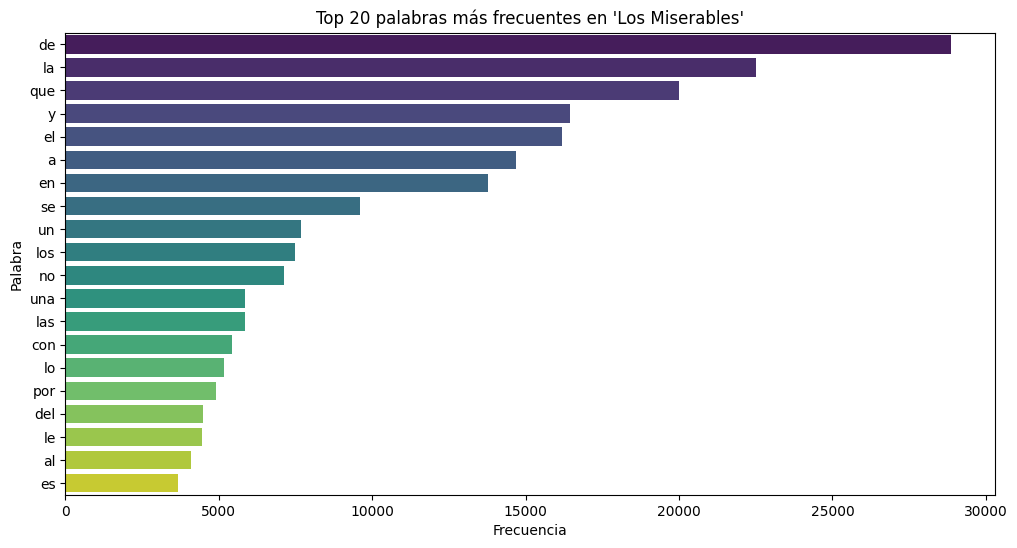

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar las 20 palabras más frecuentes
top_words = vocab_df.nlargest(20, "frecuencia")

# Configurar gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x=top_words["frecuencia"], y=top_words["palabra"], palette="viridis")
plt.xlabel("Frecuencia")
plt.ylabel("Palabra")
plt.title("Top 20 palabras más frecuentes en 'Los Miserables'")
plt.show()


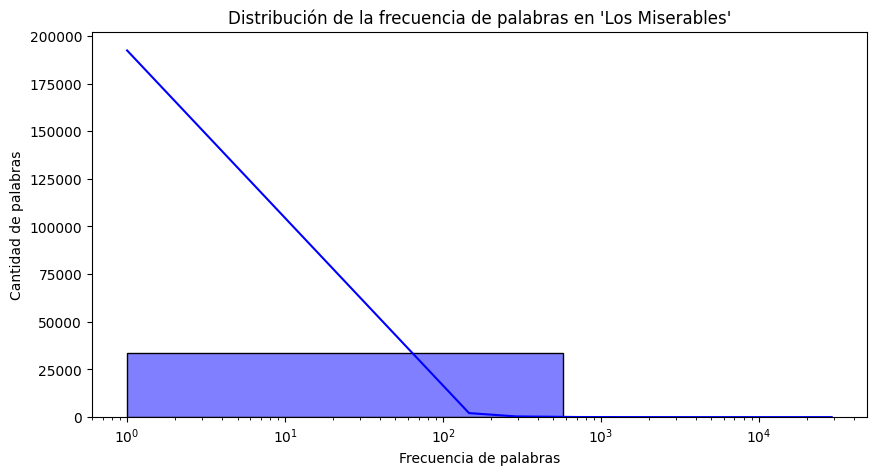

In [19]:
plt.figure(figsize=(10, 5))
sns.histplot(vocab_df["frecuencia"], bins=50, kde=True, color="blue")
plt.xlabel("Frecuencia de palabras")
plt.ylabel("Cantidad de palabras")
plt.title("Distribución de la frecuencia de palabras en 'Los Miserables'")
plt.xscale("log")  # Escala logarítmica para mejor visualización
plt.show()


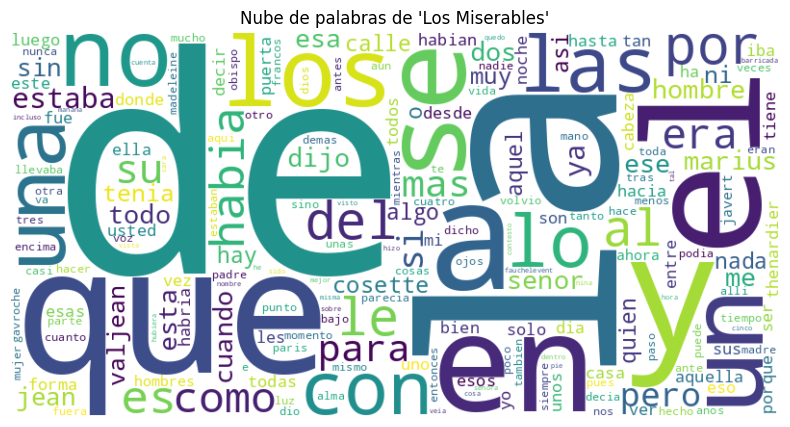

In [8]:
from wordcloud import WordCloud

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(word_counts))

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de 'Los Miserables'")
plt.show()


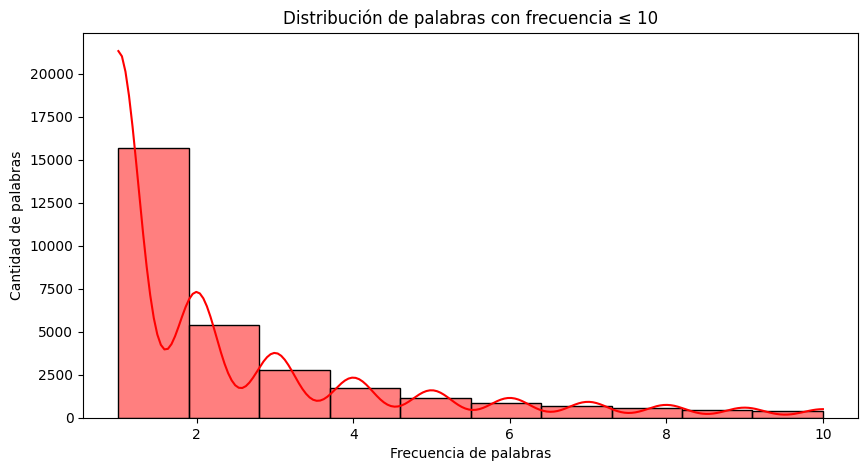

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(vocab_df[vocab_df["frecuencia"] <= 10]["frecuencia"], bins=10, kde=True, color="red")
plt.xlabel("Frecuencia de palabras")
plt.ylabel("Cantidad de palabras")
plt.title("Distribución de palabras con frecuencia ≤ 10")
plt.show()


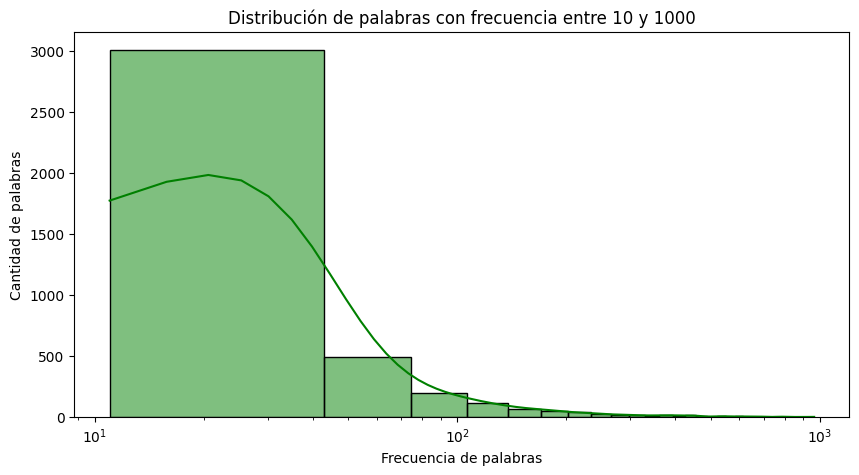

In [10]:
plt.figure(figsize=(10, 5))
sns.histplot(vocab_df[(vocab_df["frecuencia"] > 10) & (vocab_df["frecuencia"] <= 1000)]["frecuencia"], bins=30, kde=True, color="green")
plt.xlabel("Frecuencia de palabras")
plt.ylabel("Cantidad de palabras")
plt.title("Distribución de palabras con frecuencia entre 10 y 1000")
plt.xscale("log")  # Escala logarítmica
plt.show()


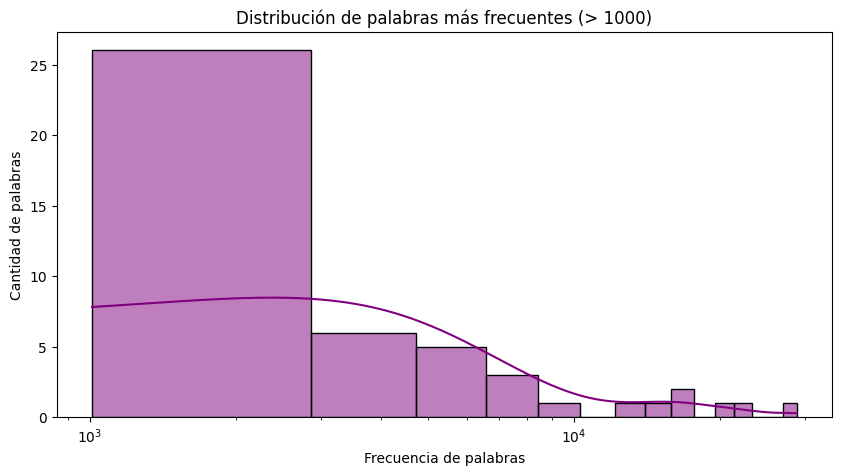

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(vocab_df[vocab_df["frecuencia"] > 1000]["frecuencia"], bins=15, kde=True, color="purple")
plt.xlabel("Frecuencia de palabras")
plt.ylabel("Cantidad de palabras")
plt.title("Distribución de palabras más frecuentes (> 1000)")
plt.xscale("log")
plt.show()


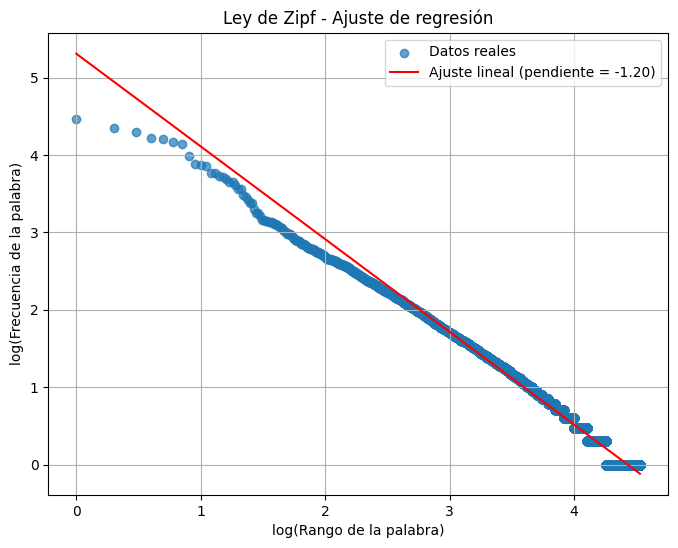

Pendiente de la regresión: -1.20


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Cargar datos desde el archivo Parquet
df = pd.read_parquet("vocabulario.parquet")

# Ordenar por frecuencia en orden descendente
df = df.sort_values(by="frecuencia", ascending=False).reset_index(drop=True)

# Asignar el rango a cada palabra
df["rango"] = df.index + 1

# Convertir a escala logarítmica
log_rango = np.log10(df["rango"])
log_frecuencia = np.log10(df["frecuencia"])

# Ajuste de regresión lineal
slope, intercept, r_value, p_value, std_err = linregress(log_rango, log_frecuencia)

# Graficar datos y ajuste
plt.figure(figsize=(8, 6))
plt.scatter(log_rango, log_frecuencia, alpha=0.7, label="Datos reales")
plt.plot(log_rango, slope * log_rango + intercept, color="red", label=f"Ajuste lineal (pendiente = {slope:.2f})")

# Etiquetas y título
plt.xlabel("log(Rango de la palabra)")
plt.ylabel("log(Frecuencia de la palabra)")
plt.title("Ley de Zipf - Ajuste de regresión")
plt.legend()
plt.grid(True)

plt.show()

# Mostrar la pendiente
print(f"Pendiente de la regresión: {slope:.2f}")


# Vocabulario sin Stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Total de palabras en el libro: 548335
Palabras únicas en el vocabulario: 33787
Número de stopwords encontradas: 266572
Número de palabras únicas que son stopwords: 202
Número de palabras únicas que NO son stopwords: 33585

🔝 100 palabras más frecuentes (sin stopwords):
           palabra  frecuencia
532          habia        3659
14             mas        2387
75              si        2005
550         marius        1403
55          hombre        1398
...            ...         ...
254      madeleine         305
863       mientras         302
211           hace         300
264   fauchelevent         300
2319      contesto         300

[100 rows x 2 columns]


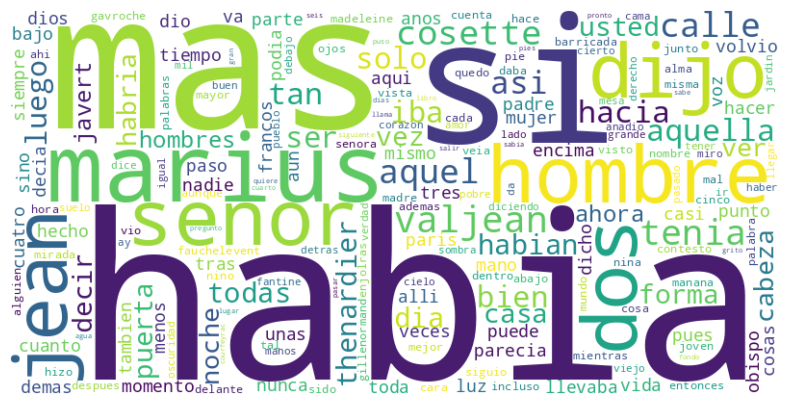

In [21]:
from pdfminer.high_level import extract_text
import pandas as pd
import re
import unicodedata
from collections import Counter
import pyarrow.parquet as pq
import pyarrow as pa
from nltk.corpus import stopwords
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Descargar stopwords
nltk.download("stopwords")

# Ruta del archivo PDF
pdf_path = "2866851.pdf"
# pdf_path = "Los-miserables.pdf" # Para utilizar el libro de la Fundación Carlos Slim

# Extraer texto del PDF
text = extract_text(pdf_path)

# Dividir en líneas y guardar en CSV
lines = text.split("\n")
df = pd.DataFrame({"texto": lines})
df.to_csv("los_miserables.csv", index=False, encoding="utf-8")

# Función para limpiar el texto
def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8")
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Limpiar el DataFrame
df = df.dropna(subset=["texto"])
df["texto"] = df["texto"].astype(str).apply(clean_text)

# Tokenizar el texto
words = " ".join(df["texto"]).split()

# Obtener lista de stopwords en español
stop_words = set(stopwords.words("spanish"))

# Contar stopwords en el texto
stopwords_count = sum(1 for word in words if word in stop_words)

# Filtrar stopwords para el vocabulario
filtered_words = [word for word in words if word not in stop_words]

# Contar frecuencia de palabras (sin stopwords)
word_counts = Counter(filtered_words)

# Crear DataFrame con el vocabulario
vocab_df = pd.DataFrame(word_counts.items(), columns=["palabra", "frecuencia"])

# Guardar en formato Parquet
table = pa.Table.from_pandas(vocab_df)
pq.write_table(table, "vocabulario.parquet")

# Obtener palabras únicas
unique_words = set(words)

# Contar cuántas palabras únicas son stopwords
unique_stopwords_count = sum(1 for word in unique_words if word in stop_words)

# Estadísticas
total_words = len(words)  # Total de palabras (incluyendo stopwords)
unique_words_count = len(unique_words)  # Total de palabras únicas (incluyendo stopwords)
unique_non_stopwords_count = unique_words_count - unique_stopwords_count  # Palabras únicas sin stopwords

print(f"Total de palabras en el libro: {total_words}")
print(f"Palabras únicas en el vocabulario: {unique_words_count}")
print(f"Número de stopwords encontradas: {stopwords_count}")
print(f"Número de palabras únicas que son stopwords: {unique_stopwords_count}")
print(f"Número de palabras únicas que NO son stopwords: {unique_non_stopwords_count}")

# Top 100 palabras más frecuentes (sin stopwords)
print("\n🔝 100 palabras más frecuentes (sin stopwords):")
print(vocab_df.nlargest(100, "frecuencia"))

# Nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_counts)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()